## Pre-processing and Clipping TUH dataset for REST

In this note book we show firstly how to clip and process the data followed by [DCRNN](https://arxiv.org/abs/2104.08336). We first import the libraries.

In [15]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import data_utils as ps
import pyedflib
import glob
import os
from tqdm import tqdm
import csv
from torch.utils.data import Dataset, DataLoader
from random import randint
import random
import h5py
import torch
import data_utils

### Building functions for pre-processing
Here we create the functions needed for pre-processing.

*build_data_directory_patient*: is a function for finding the directory of all the patients in the TUH dataset.

*build_data_dic*: For appending all the data directories.

*raw_eeg_loader*: Loading the EEG for each directory.

*get_seiz_times*: Finding onsets and end of seizures.

In [17]:
def build_data_directory_patient (train_set_directory , patient):
    
    patient_i_session_dir = train_set_directory + patient

    session_list =  [ f.name for f in os.scandir(patient_i_session_dir) if f.is_dir() ]

    D = []
    Directory = []

    for ses_id , ses in enumerate(session_list):


        montage =   [f.name for f in os.scandir(patient_i_session_dir+'/'+ses)  if f.is_dir()]


        data_dir = patient_i_session_dir+'/'+ses+'/'+montage[0]

        extension = 'edf'
        os.chdir(data_dir)
        result = glob.glob('*.{}'.format(extension))


        D.append([(data_dir+ '/' + r).replace('.edf', '') for r in result])
        
        for d in D:
            for dd in d:
                Directory.append(dd)

    return  np.unique(Directory)  



def build_data_dic (train_set_directory):
    
    Dir = []
    patients_list =  [ f.name for f in os.scandir(train_set_directory) if f.is_dir() ]
#     patients_list.remove('.ipynb_checkpoints')

    for p in tqdm(patients_list):

        dic = build_data_directory_patient('/home/afzal/datasets/tuh_eeg_datases/edf/train/' , p)
        
        [Dir.append(d)  for d in dic]
    
    
    return np.array(Dir)
    

def raw_eeg_loader(dir_):

    extension = '.edf'
    data = mne.io.read_raw_edf(dir_+extension , verbose=False)
    
    return data

def get_seiz_times(path):
    
    seizure_times = []
    with open(path + '.csv_bi') as f:
        for line in f.readlines():
            
            if "seiz" in line:  # if seizure
                # seizure start and end time
                seizure_times.append(
                    [
                        float(line.split(",")[1]),
                        float(line.split(",")[2]),
                    ]
                )
                
    return seizure_times

                       
train_set_directory ='/home/afzal/datasets/tuh_eeg_datases/edf/train/'

INCLUDED_CHANNELS = [
    'EEG FP1',
    'EEG FP2',
    'EEG F3',
    'EEG F4',
    'EEG C3',
    'EEG C4',
    'EEG P3',
    'EEG P4',
    'EEG O1',
    'EEG O2',
    'EEG F7',
    'EEG F8',
    'EEG T3',
    'EEG T4',
    'EEG T5',
    'EEG T6',
    'EEG FZ',
    'EEG CZ',
    'EEG PZ']
        
Dic = build_data_dic(train_set_directory)


100%|██████████| 580/580 [00:29<00:00, 19.45it/s]


### Simple Plot of EEG waves 

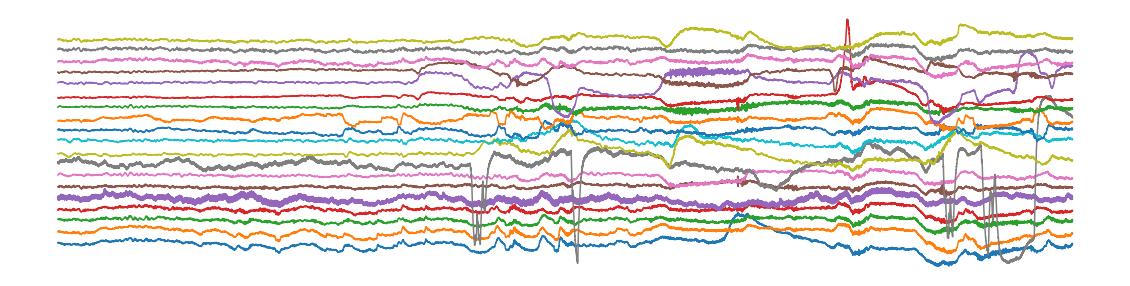

In [42]:
dir_ = Dic[1000]
Raw_file = raw_eeg_loader(dir_)

mon_id = Raw_file.ch_names[0].split('-')[1]

fs = 1/(Raw_file.times[1] - Raw_file.times[0])  
eeg_ch = [ch +'-'+ mon_id  for ch in INCLUDED_CHANNELS ]     
eeg_signal = Raw_file.pick_channels(eeg_ch).get_data()

plt.figure(figsize = (20,5))

for i in range(19):
    
    plt.plot(i/3000+eeg_signal[i,6000:20000].T )
    
plt.axis(False)
plt.savefig('/home/afzal/datasets/tuh_eeg_datases/edf/sa.png')

### Processing and Clipping

This part is indeed simple by defining the T below we define the window clip opf the EEG for processing and the code automaticcaly will process all data and then save it as seperate files for each patient. First it will save the information of all patinets in a text file.

In [18]:
T = 60
seiz_tuple = []

for item in tqdm(Dic):
    
    seiz_time = get_seiz_times(item)
    
    if len(seiz_time) != 0:
        
        for times in seiz_time:
            
            start_time = times[0]
            end_time = times[1]
            
            clip_idx =  np.arange(np.floor(start_time/T),np.ceil(end_time/T) , dtype=int )  
            if len(clip_idx) > 0 :
                [seiz_tuple.append([item,c,1]) for c in clip_idx]  

100%|██████████| 4664/4664 [01:13<00:00, 63.88it/s]


In [ ]:
import random
bckg_tuple = []
random.seed(123)
for item in tqdm(Dic):
    
    seiz_time = get_seiz_times(item)
    
    if len(seiz_time) == 0:
        
        data_len = np.floor( raw_eeg_loader(item).times[-1]/T-2) 
        
        if data_len > 0:
            
            clip_idx =  np.arange(0,data_len, dtype=int)
            [bckg_tuple.append([item,c,0]) for c in clip_idx]
            


 11%|█         | 509/4664 [00:18<02:44, 25.30it/s]

In [ ]:
bckg_tuple = random.sample(bckg_tuple,  len(seiz_tuple) )
len(bckg_tuple) , len(seiz_tuple)

### Saving  clipped data information as text

In [ ]:
with open("./tuh_eeg_datases/edf/seiz_tuple.txt", "w") as f:
    for s in seiz_tuple:
        f.write(str(s) +"\n")
        
with open(".datasets/tuh_eeg_datases/edf/bckg_tuple.txt", "w") as f:
    for s in bckg_tuple:
        f.write(str(s) +"\n")

In [ ]:
seizure_file = "./tuh_eeg_datases/edf/seiz_tuple.txt"
bckg_file = "./datasets/tuh_eeg_datases/edf/bckg_tuple.txt"

def parsetxtfile(seizure_file , bckg_file , seed ):
    
    random.seed(seed)
    
    seizure_contents = open(seizure_file, "r") 
    non_seizure_contents = open(bckg_file, "r") 

    seiz_list = []
    non_seiz_list = []
    bckg_list = []
    dir_ = []

    dir_.extend(seizure_contents.readlines())

    for idx in range(len(dir_)):

        tuple_seiz = [eval(dir_[idx].split(',')[0].split('[')[1]) , 
        int( dir_[idx].split(',')[1] )  , int( dir_[idx].split(',')[-1] .split(']\n')[0] )]
        seiz_list.append(tuple_seiz)

    dir_ = []
    dir_.extend(non_seizure_contents.readlines())

    for idx in range(len(dir_)):

        tuple_bckg = [eval(dir_[idx].split(',')[0].split('[')[1]) , 
        int( dir_[idx].split(',')[1] )  , int( dir_[idx].split(',')[-1] .split(']\n')[0] )]
        bckg_list.append(tuple_bckg)



    combined_list = bckg_list + seiz_list

    random.shuffle(combined_list)
    
    return combined_list 


### Building the data

Here we build the dataset based on what is the ictal and non-ictal samples.

In [ ]:
time_step = 1
to_freq = 200 
seed=123 

ii = 0

combined_list = parsetxtfile(seizure_file , bckg_file , 123)
dirs = [elemnt[0].split('/')[-1] for elemnt in combined_list]


for elemnt in tqdm( np.unique (dirs)):
    
    matches =  [ i for i,x in enumerate(dirs) if x == elemnt ]
    
    C = [combined_list[clpind] for clpind in matches]
    
    eeg_dir = C[0][0]
    
    Raw_file = raw_eeg_loader(eeg_dir)
    
    mon_id = Raw_file.ch_names[0].split('-')[1]

    fs = 1/(Raw_file.times[1] - Raw_file.times[0])  
    eeg_ch = [ch +'-'+ mon_id  for ch in INCLUDED_CHANNELS ]     
    eeg_signal = Raw_file.pick_channels(eeg_ch).get_data()
    
    resampled_eeg = ps.resample_data(eeg_signal , fs = fs , to_freq = to_freq)

    for label , clip_idx in  zip((np.array(C)[:,2]).astype(int) , (np.array(C)[:,1]).astype(int)):
        
#         ii = ii+1
#         print((np.array(C)[:,1]).astype(int) , eeg_dir , label)
    
        start_window = int(clip_idx * to_freq* T)

        eeg_slc = [resampled_eeg[:,start_window + t*to_freq:start_window + (t+1)*to_freq]  for t in range(T)]
        
        a = [e.shape[1] for e in eeg_slc]
        
        if np.sum(a)/200 != T:
            print(label , elemnt)
            continue

        h5_file = "/home/afzal/datasets/tuh_eeg_datases/edf/c60_t/" 
        eeg_clip = np.stack( eeg_slc ,0)
        
        if eeg_clip.shape != (T,19,200):
            print(eeg_clip.shape , elemnt)
            continue
         
        
        with h5py.File(h5_file + eeg_dir.split('/')[-1] + '_' + str(clip_idx) +'.h5' , "w") as hf: 
            hf.create_dataset(eeg_dir.split('/')[-1] + '_' + str(clip_idx) +'.h5' , data = eeg_clip  )

        h5_file_label = "/home/afzal/datasets/tuh_eeg_datases/edf/l60_t/" 
        
        with h5py.File(h5_file_label +eeg_dir.split('/')[-1] + '_' + str(clip_idx) +'.h5', "w") as hf_label: 
            hf_label.create_dataset(eeg_dir.split('/')[-1]+ '_' + str(clip_idx) +'.h5' , data = label  )
    

### Load data for each patient and concat the whole data 

At the end of this part we will have out data needed for the training.

In [ ]:
path = '/net/inltitan1/scratch2/Arshia/TUH_Clipped_Data'
edf_dir = '/home/afzal/datasets/tuh_eeg_datases/edf/'

label_dir =  (edf_dir+'l60_t/')
h5_file_dir =  (edf_dir+'c60_t/')

EEG = []
Label = []

for idx in tqdm(range(len(os.listdir(h5_file_dir)))):

    clip_list = os.listdir(h5_file_dir)

    with h5py.File( h5_file_dir + clip_list[idx], "r") as f:

        eeg_clip = np.array(f[list(f.keys())[0]])

        label_list = os.listdir(label_dir)
        index = np.argwhere( np.array(label_list) == clip_list[idx])   
        
        EEG.append(eeg_clip)

    with h5py.File(label_dir +label_list[int(index)], "r") as f:

        label = np.array(f[list(f.keys())[0]])
        
        Label.append(label)

### Sample of Loading the data

This data is what we use for training REST in the other files.

In [ ]:
path = './TUH_Clipped_Data'

with h5py.File(path +'/clip_data_60_second' +'.h5' , "w") as hf: 
    hf.create_dataset( '/clip_data_60_second' +'.h5'  , data = np.array(EEG)  )

        
with h5py.File(path + '/label_60_second' +'.h5', "w") as hf_label: 
    hf_label.create_dataset(  '/label_60_second' +'.h5' , data = np.array(Label)  )

In [28]:
with h5py.File( path+ '/clip_data_14' +'.h5' , "r") as f:
    
    EEG = np.array(f[list(f.keys())[0]])

        
with h5py.File(  path+ '/label_14' +'.h5', "r") as f: 
    
    Label = np.array(f[list(f.keys())[0]])
    

In [30]:
len(EEG) , len(Label)

(28604, 28604)